In [ ]:
#pip install comet_ml > /dev/null 2>&1
import comet_ml
# ENTER YOUR COMET API KEY HERE!!
COMET_API_KEY = ""

# Import Tensorflow 2.0 - 
# pip install tensorflow-macos (optimized version)
# pip install tensorflow-metal (GPU acceleration)
import tensorflow as tf

# other packages
import matplotlib.pyplot as plt
import numpy as np

/Users/danism/developer/python_trials/lab2_computer_vision/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print("GPUs available:", tf.config.list_physical_devices('GPU'))
# Check that we are using a GPU, if not switch runtimes
# using Runtime > Change Runtime Type > GPU
assert len(tf.config.list_physical_devices('GPU')) > 0
assert COMET_API_KEY != "", "Please insert your Comet API Key"

GPUs available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
# Create a Comet experiment function to track each of the training runs

def create_experiment(optimizer, learning_rate):
  # end any prior experiments
  if 'experiment' in locals():
    experiment.end()

  # initiate the comet experiment for tracking
  experiment = comet_ml.Experiment(
                  api_key=COMET_API_KEY,
                  project_name="MNIST_CNN")
  
  experiment.set_name(optimizer + "_" + learning_rate)
  return experiment


In [ ]:
# LOAD DATASET
mnist = tf.keras.datasets.mnist.load_data()

(train_images, train_labels), (test_images, test_labels) = mnist

print("Training images shape: ", train_images.shape)
print("Training labels shape: {}".format(train_labels.shape))
print("Testing images shape: {}".format(tf.shape(test_images)))
print(f"Test labels shape: {test_labels.shape} ")

Training images shape:  (60000, 28, 28)
Training labels shape: (60000,)
Testing images shape: [10000    28    28]
Test labels shape:  (10000,)


In [136]:
# PREPARE DATASET FOR CNN
# Adjust the shape of the images and normalize pixel values in the range [0,1]
print(f"{' Not normalized image values ':-^100}")
print(train_images[0])
# Mnist dataset contains images of size 28x28 and pixel values in the range [0,255]

train_images = (np.expand_dims(train_images, axis = -1)/255.0).astype(np.float32)
test_images = (np.expand_dims(test_images, axis = -1)/255.0).astype(np.float32)
train_labels = train_labels.astype(np.int64)
test_labels = test_labels.astype(np.int64)

print(f"{' Printing train_images values ':-^100}")
print(train_images[0])

----------------------------------- Not normalized image values ------------------------------------
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3  18  18  18 126 136
  175  26 166 255 247 127   0   0   0   0]
 [  0   0   0   0   0   0   0   0  30  36  94 154 170 253 253 253 253 253
  225 172 253 242 195  64   0   0   0   0]
 [  0   0   0   0   0   0   0  49 238 253 253 253 253 253 253 253 253 251
   93 

------------------------------------ Plotting 36 random images -------------------------------------
------------------------------------- Randomly selected images -------------------------------------
Random indices: [19618 35275  4859 37804 57347 43200 19259 56379 57340  9869  3057  4331
 58897 57003 20148 31461 21506 14625 40947 26494  3745 17447 16807 17382
 24513 33595 30247 52338 55984 29223  7713  9049  9278 39014 51101 59360]
--------------------------------------- Plotting the images ----------------------------------------
----------------------------------- Logging the images to Comet ------------------------------------


{'web': 'https://www.comet.com/api/image/download?imageId=8c4184c712a14c7fa00500316153a50a&experimentKey=3bd84ebba89145ee8f606d4bc443a0c2',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=8c4184c712a14c7fa00500316153a50a&experimentKey=3bd84ebba89145ee8f606d4bc443a0c2',
 'imageId': '8c4184c712a14c7fa00500316153a50a'}

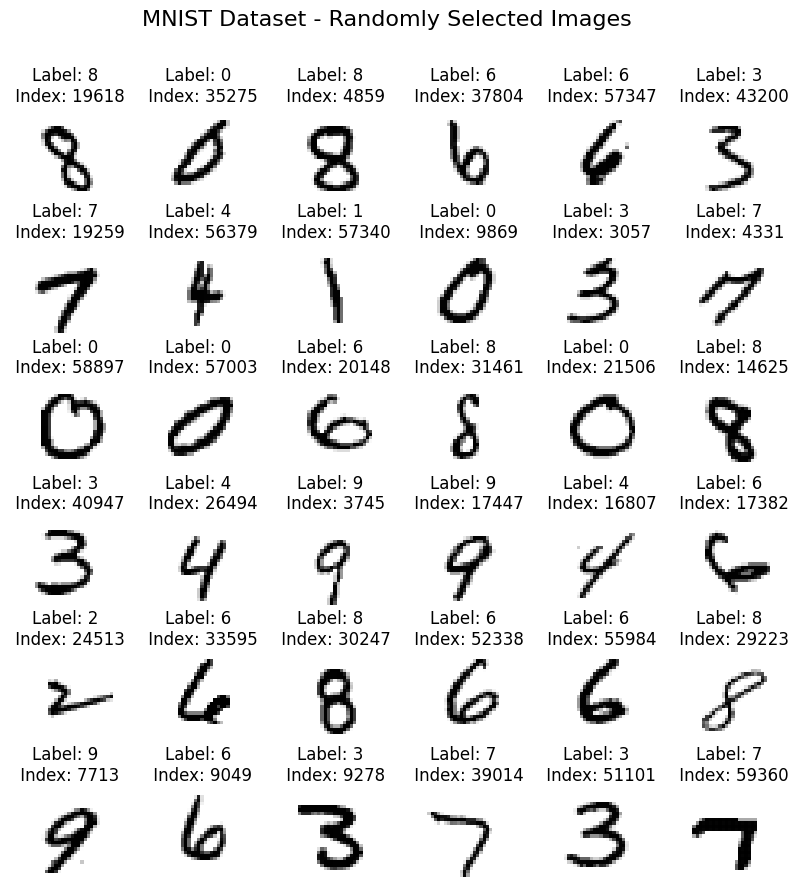

In [ ]:
# Plot 36 random images from the dataset
print(f"{ ' Plotting 36 random images ':-^100}")

print(f"{' Randomly selected images ':-^100}")
random_indices = np.random.choice(train_images.shape[0],36,replace = False)
print(f"Random indices: {random_indices}")

print(f"{' Plotting the images ':-^100}")

plt.figure(figsize=(10, 10))
for i in range(36):
    plt.subplot(6,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[random_indices[i]], cmap = plt.cm.binary)
    plt.axis('off')
    title = f"Label: {train_labels[random_indices[i]]} \n Index: {random_indices[i]}"
    plt.title(title)

plt.subplots_adjust(hspace=0.5)
plt.suptitle("MNIST Dataset - Randomly Selected Images", fontsize=16)

print(f"{' Logging the images to Comet ':-^100}")


In [293]:
# 0 DEFINE HYPERPARAMETERES + Experiment creation

params = {
    "learning_rate": 0.0001,
    "batch_size": 64,
    "num_epochs": 5,
    "loss_function": "sparse_categorical_crossentropy",
}

comet_model_fcnn = create_experiment("Adam", str(params["learning_rate"]))


COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/danisamper97/6s191-lab2-part1-fcnn/0b583990d4a54d128093753d3ec336fa

COMET INFO: Couldn't find a Git repository in '/Users/danism/developer/python_trials/lab2_computer_vision' nor in any parent directory. Set `COMET_GIT_DIRECTORY` if your Git Repository is elsewhere.


In [ ]:
# 1 CREATE A FULLY CONNECTED MODEL

print(f"{' Creating Fully Connected Neural Network ':-^100}")

def build_fc_model():
    fc_model = tf.keras.Sequential([
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation = 'relu'),
        tf.keras.layers.Dense(10, activation = 'softmax')
    ])
    return fc_model

fc_model = build_fc_model()
fc_model.summary()

----------------------------- Creating Fully Connected Neural Network ------------------------------


Model: "sequential_38"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_40 (Flatten)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_80 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_81 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [295]:
# 2 DEFINE LOSS, OPTIMIZER AND METRICS
print(f"{' Defining Loss, Optimizer and Metrics using model.compile ':-^100}")

fc_model.compile(
    loss = params['loss_function'],
    optimizer = tf.keras.optimizers.Adam(learning_rate=params['learning_rate']),
    metrics = ['accuracy']
)

--------------------- Defining Loss, Optimizer and Metrics using model.compile ---------------------


In [ ]:
# 3 TRAIN THE MODEL
print(f"{' Training the model using model.fit ':-^100}")

fc_model.fit(train_images, train_labels,batch_size = params['batch_size'], epochs = params['num_epochs'])
comet_model_fcnn.end()

# It has been seen that: 
# SGD Optimizer converges faster with higher learning rates, however, learning rates greater than
# 0.1 can cause the model to diverge. Best model: learning rate = 0.05
# Adam optimizer converges faster than SGD and requires smaller learnings rates < 0.001. Best 
# model: learning rate = 0.0005

# The best model of all is using the Adam optimizer with a learning rate of 0.0005, yielding an 
# accuracy of 0.9254.

# SGD optimizer is more sensitive to the learning rate than Adam optimizer.


-------------------------------- Training the model using model.fit --------------------------------
Epoch 1/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.6492 - loss: 1.2219
Epoch 2/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8955 - loss: 0.3901
Epoch 3/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9065 - loss: 0.3350
Epoch 4/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9169 - loss: 0.2988
Epoch 5/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9180 - loss: 0.2913


COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : Adam_0.0001
COMET INFO:     url                   : https://www.comet.com/danisamper97/6s191-lab2-part1-fcnn/0b583990d4a54d128093753d3ec336fa
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     accuracy [5]         : (0.7968500256538391, 0.9181333184242249)
COMET INFO:     batch_accuracy [470] : (0.109375, 0.96875)
COMET INFO:     batch_loss [470]     : (0.1362595558166504, 2.5157291889190674)
COMET INFO:     epoch_duration [5]   : (4.593425874998502, 4.989518415997736)
COMET INFO:     loss [5]             : (0.29155412316322327, 0.7797484993934631)
COMET INFO:   Others:
COMET INFO:     Name : Adam_0.0001
COMET INFO:   Parameters:
COMET INFO:  

In [292]:
# 4 EVALUATE THE MODEL ON TEST DATASET
print(f"{' Evaluating the model using model.evaluate ':-^100}")

test_loss, test_accuracy = fc_model.evaluate(test_images, test_labels, batch_size = params['batch_size'])

print(f"Test accuracy: {test_accuracy:.4f}")

# When a machine learning model performs worse on new data than on its training data is an example
# of overfitting = the accuracy on the test dataset is lower than the accuracy on the training dataset.

# The max accuracy on the training dataset that we can achieve using a fully connected neural network
# is 0.92. How can we do better?

---------------------------- Evaluating the model using model.evaluate -----------------------------
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9138 - loss: 0.3025
Test accuracy: 0.9262


In [ ]:
# 0 DEFINE HYPERPARAMETERES + Experiment creation

params = {
    "learning_rate": 0.0005,
    "batch_size": 64,
    "num_epochs": 5,
    "loss_function": "sparse_categorical_crossentropy",
}

comet_model_cnn = create_experiment("Adam", str(params["learning_rate"]))


In [356]:
# 1 DEFINE THE CNN MODEL
print(f"{' Creating Convolutional Neural Network ':-^100}")
cnn_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(24,kernel_size=(3,3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Conv2D(36,kernel_size=(3,3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dense(10, activation = 'softmax')
])

cnn_model.predict(train_images[[0]])
cnn_model.summary()

------------------------------ Creating Convolutional Neural Network -------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Model: "sequential_48"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_38 (Conv2D)              │ (1, 26, 26, 24)        │           240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_37 (MaxPooling2D) │ (1, 13, 13, 24)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (1, 11, 11, 36)        │         7,812 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_38 (MaxPooling2D) │ (1, 5, 5, 36)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_50 (Flatten)            │ (1, 900)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_100 (Dense)               │ (1, 128)               │       115,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_101 (Dense)               │ (1, 10)                │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 124,670 (486.99 KB)

 Trainable params: 124,670 (486.99 KB)

 Non-trainable params: 0 (0.00 B)

In [359]:
# 2 DEFINE LOSS, OPTIMIZER AND METRICS
print(f"{' Defining Loss, Optimizer and Metrics using model.compile ':-^100}")

cnn_model.compile(
    loss = params['loss_function'],
    optimizer = tf.keras.optimizers.Adam(learning_rate = params['learning_rate']),
    metrics = ['accuracy']
)

--------------------- Defining Loss, Optimizer and Metrics using model.compile ---------------------


In [360]:
# 3 TRAIN THE MODEL USING MODEL.FIT
print(f"{' Training the model using model.fit ':-^100}")

cnn_model.fit(train_images, train_labels, batch_size = params['batch_size'], epochs = params['num_epochs'])
comet_model_cnn.end()

-------------------------------- Training the model using model.fit --------------------------------
Epoch 1/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.8717 - loss: 0.4760
Epoch 2/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.9729 - loss: 0.0888
Epoch 3/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.9776 - loss: 0.0723
Epoch 4/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9811 - loss: 0.0616
Epoch 5/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.9823 - loss: 0.0633


In [361]:
# 4 EVALUATE THE MODEL USING MODEL.EVALUATE
print(f"{' Evaluating the model using model.evaluate ':-^100}")

test_loss, test_accuracy = cnn_model.evaluate(test_images, test_labels, batch_size = params['batch_size'])

print(f"Test accuracy: {test_accuracy:.4f}")


# Best model for: 
# SGD Optimizer: learning rate = 0.01
# Adam Optimizer: learning rate = 0.0005

---------------------------- Evaluating the model using model.evaluate -----------------------------
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9814 - loss: 0.0737
Test accuracy: 0.9838


------------------------------ Making predictions using model.predict ------------------------------
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Random index: 4964
[3.19142607e-13 2.65112760e-07 9.99999642e-01 3.70248827e-08
 6.15129268e-21 1.17035231e-18 5.97539816e-15 1.00191556e-13
 4.11434858e-10 1.43654014e-19]


Text(0.5, 1.0, 'Predicted label: 2 \n Actual label: 2')

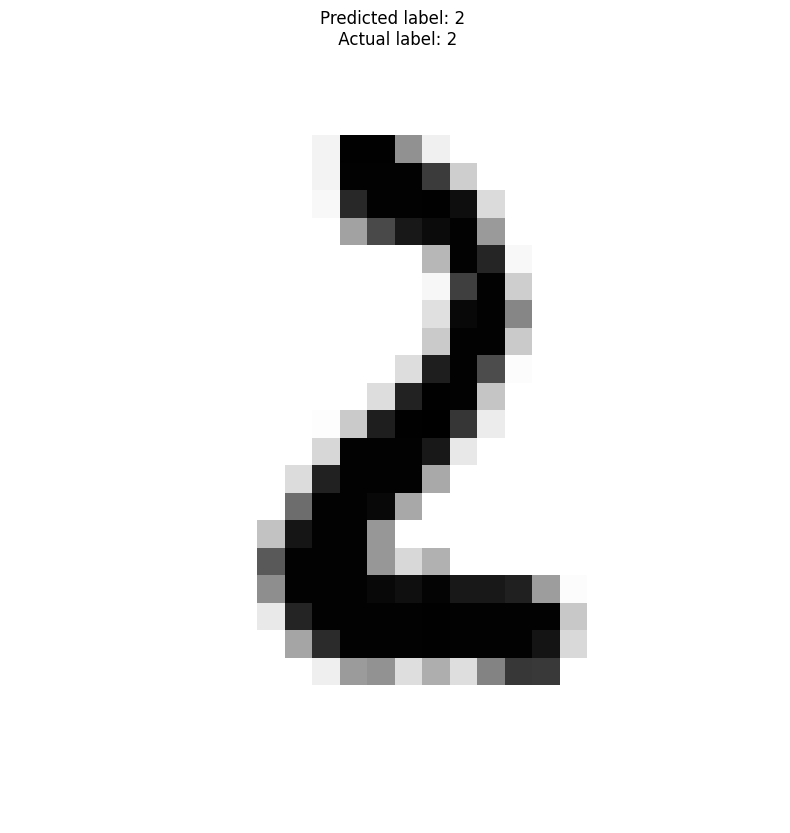

In [ ]:
# 5 MAKE PREDICTION WITH CNN MODEL
print(f"{' Making predictions using model.predict ':-^100}")

predictions = cnn_model.predict(test_images)


Text(0.5, 0.98, 'MNIST Dataset - Randomly Selected Images')

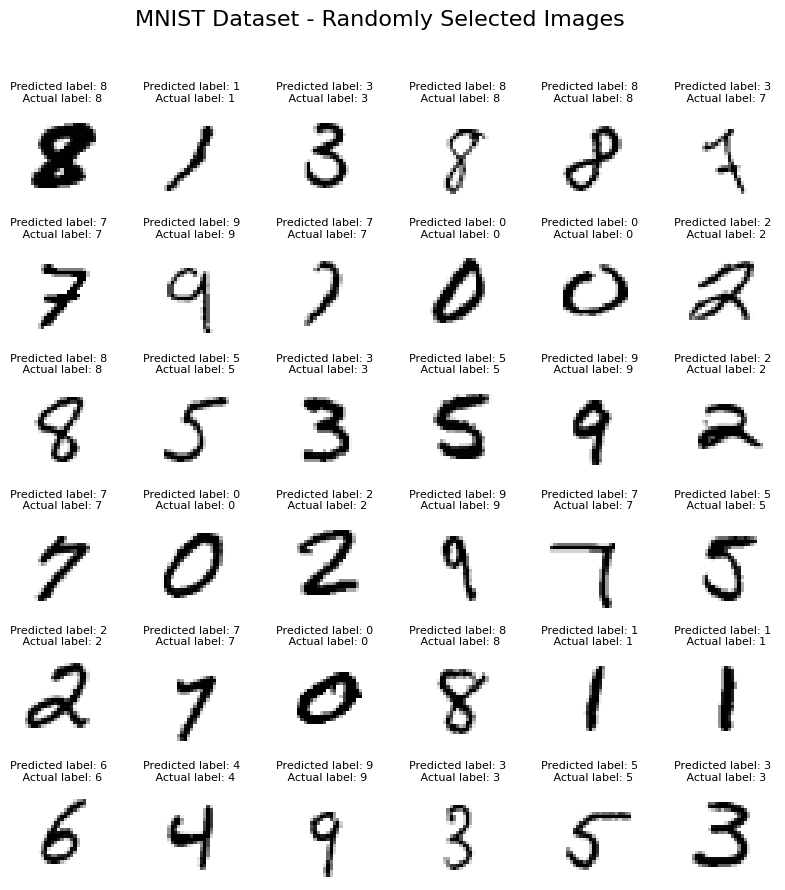

In [363]:
# Visualize the classification results
plt.figure(figsize=(10, 10))

random_indices = np.random.choice(test_images.shape[0],36,replace = False)

for i in range(36):
    plt.subplot(6,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_images[random_indices[i]], cmap = plt.cm.binary)
    plt.axis('off')
    plt.title(f"Predicted label: {np.argmax(predictions[random_indices[i]])} \n Actual label: {test_labels[random_indices[i]]}", fontsize = 8)

plt.subplots_adjust(hspace=0.5)
plt.suptitle("MNIST Dataset - Randomly Selected Images", fontsize=16)